In [23]:
import copy
from datetime import datetime
import itertools
import os
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
from pydantic import BaseModel, Field
from transformers import AutoTokenizer

In [2]:
from pydantic_settings import BaseSettings, SettingsConfigDict

class EnvSettings(BaseSettings):
    model_config = SettingsConfigDict(
        env_file="../.env", env_file_encoding="utf-8", extra="ignore"
    )
    embedding_base_url: str
    embedding_api_key: str
    embedding_model: str
    embedding_model_dir: str
    
    sample_data_dir: str
    pipeline_src_dir: str
settings = EnvSettings()

import sys
sys.path.append(settings.pipeline_src_dir)

In [4]:
class DBSettings(BaseSettings):
    model_config = SettingsConfigDict(
        env_file="database/.env", env_file_encoding="utf-8", extra="ignore"
    )
    postgres_user: str
    postgres_password: str
    postgres_db: str
    postgres_url: str
    postgres_port: str

db_settings = DBSettings()
print(db_settings.postgres_db)

pgvector_llamaindex


# 1. Prepare Embedding & VectorStore

In [5]:
from llama_index.core import Settings
from llama_index.embeddings.text_embeddings_inference import (
    TextEmbeddingsInference,
)

from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.core import VectorStoreIndex
from llama_index.vector_stores.postgres import PGVectorStore

from sqlalchemy import make_url

In [6]:
# https://docs.llamaindex.ai/en/stable/examples/embeddings/text_embedding_inference/
embed_model = TextEmbeddingsInference(
    model_name=settings.embedding_model,
    base_url=settings.embedding_base_url,
    timeout=60,
    embed_batch_size=10,
)
Settings.embed_model = embed_model

In [7]:
import psycopg2
# connection_string = "postgresql://{}:{}@localhost:{}/{}".format(
connection_string = "postgresql://{}:{}@localhost:{}/{}".format(
    db_settings.postgres_user,
    db_settings.postgres_password,
    db_settings.postgres_port,
    db_settings.postgres_db
)

db_name = db_settings.postgres_db
print(f"DB: {db_name}")
conn = psycopg2.connect(connection_string)
conn.autocommit=True

DB: pgvector_llamaindex


In [9]:
## Initialize vector store instance
url = make_url(connection_string)

## hnsw indexing config
hnsw_config = {
    "hnsw_m": 16,
    "hnsw_ef_construction": 64,
    "hnsw_ef_search": 40,
    "hnsw_dist_method": "vector_cosine_ops",
}

## Make Abstract Vectorstore
* for embedding title+abstract

In [10]:
abstract_vector_store = PGVectorStore.from_params(
    database=db_name,
    host=url.host,
    password=url.password,
    port=url.port,
    user=url.username,
    table_name="paper_abstract",
    embed_dim=1024,  #bge-m3
    hnsw_kwargs=hnsw_config,
)

## create storage context
abstact_storage_context = StorageContext.from_defaults(vector_store=abstract_vector_store)

# 2. Analyze Data

In [11]:
## Load Sample
df = pd.read_parquet(settings.sample_data_dir)
df = df.sample(100)
print(df.shape, df.columns)

(100, 7) Index(['id', 'title', 'abstract', 'authors', 'published_date', 'link',
       'markdown'],
      dtype='object')


In [12]:
df.iloc[0]

id                                                       2306.16925
title             MIS-FM: 3D Medical Image Segmentation using Fo...
abstract          Pretraining with large-scale 3D volumes has a ...
authors           Guotai Wang, Jianghao Wu, Xiangde Luo, Xinglon...
published_date                                 2023-06-29T13:22:13Z
link                              http://arxiv.org/abs/2306.16925v1
markdown          # MIS-FM: 3D Medical Image Segmentation using ...
Name: 18077, dtype: object

In [13]:
tokenizer = AutoTokenizer.from_pretrained(settings.embedding_model_dir)
def count_tokens(tokenizer, text):
    return len(tokenizer(text)['input_ids'])

count_tokens(tokenizer, 'hello world')

5

In [14]:
ABSTRACT_TEMPLATE = '''Title: {title}
Abstract:
{abstract}'''

def format_abstract(title = "", abstract = ""):
    formatted_abstract = copy.deepcopy(ABSTRACT_TEMPLATE)
    return formatted_abstract.format(title=title, abstract=abstract)

In [16]:
formatted_abstracts = []
for i in range(df.shape[0]):
    formatted_abstract = format_abstract(
        title = df.iloc[i]["title"],
        abstract = df.iloc[i]["abstract"],
    )
    formatted_abstracts.append(formatted_abstract)

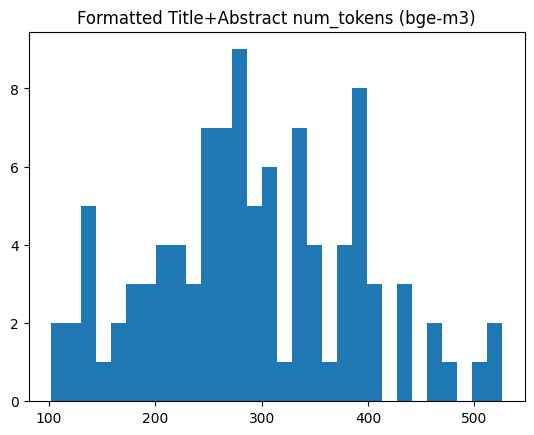

In [19]:
formatted_abstract_num_tokens = [count_tokens(tokenizer, x) for x in formatted_abstracts]
plt.hist(formatted_abstract_num_tokens, bins = 30)
plt.title("Formatted Title+Abstract num_tokens (bge-m3)")
plt.show()

# 3. Make llama-index Documents

In [20]:
from llama_index.core import Document

In [24]:
df.iloc[0]["published_date"]

'2023-06-29T13:22:13Z'

In [25]:
type(df.iloc[0]["published_date"])
datetime.strptime(df.iloc[0]["published_date"], '%Y-%m-%dT%H:%M:%SZ')

datetime.datetime(2023, 6, 29, 13, 22, 13)

In [26]:
abstract_documents = []

for i in range(df.shape[0]):
    published_date = datetime.strptime(df.iloc[i]["published_date"], '%Y-%m-%dT%H:%M:%SZ')
    document = Document(
        text = formatted_abstracts[i],
        metadata = {
            "paper_information_id": i, ## mock id, use df row id
            "published_date": published_date.strftime('%Y-%m-%d %H:%M:%S')
        },
        text_template='{content}'
    )
    abstract_documents.append(document)

# 4. Insert Documents

In [28]:
## Must add at least one document to make index like this
# abstact_storage_index = VectorStoreIndex(storage_context=abstact_storage_context)

# Initialize index from documents
abstact_storage_index = VectorStoreIndex.from_documents(
    abstract_documents,
    storage_context=abstact_storage_context,
    show_progress=True
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Parsing nodes:   0%|          | 0/100 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/100 [00:00<?, ?it/s]

# 5. Test Retrieval

In [29]:
retriever_args = {"similarity_top_k": 10}
retriever = abstact_storage_index.as_retriever(**retriever_args)

In [30]:
## Simple query
query = "Retrieval Augmented Generation"
nodes = retriever.retrieve(query)
nodes

[NodeWithScore(node=TextNode(id_='7eb94f34-af50-4f8f-967a-6b779229ef2d', embedding=None, metadata={'paper_information_id': 4, 'published_date': '2023-08-25 19:35:58'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7eb5f76f-a9a4-43ed-9b14-77f26e097a9e', node_type='4', metadata={'paper_information_id': 4, 'published_date': '2023-08-25 19:35:58'}, hash='302d9152de24a6f6fdac54b594c9f83f506776238daab61b8ab92d02a0bd1ec4')}, metadata_template='{key}: {value}', metadata_separator='\n', text="Title: Emulating Radiative Transfer with Artificial Neural Networks\nAbstract:\nForward-modeling observables from galaxy simulations enables direct\ncomparisons between theory and observations. To generate synthetic spectral\nenergy distributions (SEDs) that include dust absorption, re-emission, and\nscattering, Monte Carlo radiative transfer is often used in post-processing on\na galaxy-by-galaxy basis. However, this

In [31]:
for i, node in enumerate(nodes):
    ## Score
    score = node.score
    ## Source
    paper_info_id = node.metadata['paper_information_id']
    title = df.iloc[paper_info_id]["title"]
    abstract = df.iloc[paper_info_id]["abstract"]
    print("Result {} - {:.3f}".format(i, score))
    print(paper_info_id, title)
    print(abstract[:100])
    print('-'*30)

Result 0 - 0.537
4 Emulating Radiative Transfer with Artificial Neural Networks
Forward-modeling observables from galaxy simulations enables direct
comparisons between theory and o
------------------------------
Result 1 - 0.530
97 Counterfactual Image Generation for adversarially robust and
  interpretable Classifiers
Neural Image Classifiers are effective but inherently hard to interpret and
susceptible to adversari
------------------------------
Result 2 - 0.522
17 Active Learning for Object Detection with Non-Redundant Informative
  Sampling
Curating an informative and representative dataset is essential for enhancing
the performance of 2D 
------------------------------
Result 3 - 0.508
1 An extensible point-based method for data chart value detection
We present an extensible method for identifying semantic points to reverse
engineer (i.e. extract th
------------------------------
Result 4 - 0.505
86 Learning Symbolic Representations Through Joint GEnerative and
  DIscriminative T